In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from mnist_model import generator,discriminator
import utils

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 2e-4
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
# trainx = 2.*trainx-1.
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
testy.astype(np.int32)
trainy.astype(np.int32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


array([7, 3, 4, ..., 2, 1, 2], dtype=int32)

In [4]:
labeled =10000
trainx_unl = trainx.copy()
inds = np.random.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']
print(trainx.shape)

(60000, 28, 28, 1)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
train_triger= iterator.make_initializer(train_dataset)
test_triger= iterator.make_initializer(test_dataset)

In [27]:
def lenet(x,training_pl,getter=None,reuse=tf.AUTO_REUSE):
    with tf.variable_scope("classifier", reuse=reuse,custom_getter=getter):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.reshape(x, [-1, 7 * 7 * 64])
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x

In [28]:
label = tf.cast(next_label,tf.int64)
training_pl  = tf.placeholder(tf.bool,[])
logits = lenet(next_element,training_pl)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=label)
with tf.variable_scope("classifier",reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train_op = optimizer.minimize(xloss)

correct_prediction = tf.equal(tf.argmax(logits,1),label)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [29]:
def ema_getter(getter, name, *args, **kwargs):
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var 

In [56]:
# with tf.variable_scope("ema",reuse=tf.AUTO_REUSE):
ema = tf.train.ExponentialMovingAverage(decay=0.8)
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='classifier')
maintain_averages_op = ema.apply(dvars)

with tf.control_dependencies([train_op]):
    train_op = tf.group(maintain_averages_op)

logits_ema = lenet(next_element,training_pl, getter=ema_getter,reuse=True)
correct_prediction_ema = tf.equal(tf.argmax(logits_ema,1),label)
accuracy_ema = tf.reduce_mean(tf.cast(correct_prediction_ema, tf.float32))

ValueError: Variable classifier/conv2d/kernel/ExponentialMovingAverage/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-52-c8eb0c8d9513>", line 4, in <module>
    maintain_averages_op = ema.apply(dvars)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):


In [53]:
ema.average(dvars[1])

<tf.Variable 'classifier/conv2d/bias/ExponentialMovingAverage:0' shape=(32,) dtype=float32_ref>

In [54]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [55]:
sess.run(train_triger)
for i in tqdm(range(20001)):
    xl,_,acc = sess.run([xloss,train_op,accuracy],feed_dict={training_pl:True})
    if i % 100 == 0:
        sess.run(test_triger)
        test_acc = 0
        for n in range(nr_batch_test):
            test_acc  += sess.run(accuracy,feed_dict={training_pl:False})
        test_acc /= nr_batch_test
        print("Step: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(i, xl, acc * 100,test_acc*100))
        print(sess.run(accuracy_ema,{training_pl:False}))
#         sess.run(maintain_averages_op)
        print(sess.run(ema.average(dvars[1])))

Step: 0, xloss: 2.28551, training acc: 3.00%, test acc: 11.99%
0.07
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Step: 100, xloss: 0.54008, training acc: 82.00%, test acc: 85.60%
0.87
[ 6.1210399e-03  3.9008462e-03 -2.2223171e-04  1.2064143e-03
  8.0644025e-04  1.4717373e-03  3.5472212e-03  2.9502783e-03
 -6.7206274e-06 -2.2183075e-04  2.9902530e-03  2.5183670e-04
 -2.9266408e-05  2.5846700e-03  3.8052648e-03  4.3840469e-03
  1.8161080e-03  8.9306681e-04  2.4963063e-03  3.6903119e-03
  7.9938034e-03  4.4784751e-03  7.2208038e-03  6.7919330e-03
 -3.3095645e-04 -1.1680327e-04  3.4115280e-04  4.5120427e-03
  1.5912455e-03  3.6628195e-03  1.7168481e-03 -2.5763400e-04]
Step: 200, xloss: 0.27779, training acc: 90.00%, test acc: 91.45%
0.95
[ 8.5493606e-03  5.7032644e-03 -1.3229410e-04  2.9856077e-04
  2.0687769e-03  6.8425661e-04  3.3642219e-03  2.2295536e-03
 -2.5824282e-05 -4.7406647e-04  2.7968015e-03  4.0109653e-06
  1.0436110e-05  1.

KeyboardInterrupt: 

In [ ]:
sess.run(test_triger)
xx,yy=sess.run([next_element,next_label])

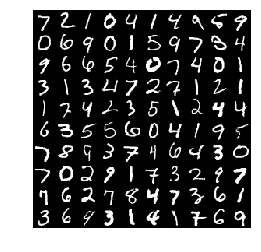

In [19]:
show_digits(xx)

In [20]:
yy

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=uint8)

In [21]:
trainx.shape

(100, 28, 28, 1)